# QBO in OpenIFS 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean 
from scipy.stats import linregress

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36289 instead
  expected, actual


In [4]:
client

Client Scheduler: tcp://127.0.0.1:43201 Dashboard: http://127.0.0.1:36289/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [6]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    esmdir2 = '/gxfs_work1/geomar/smomw352/esm-slask/'

In [7]:
exp_list = ['FOCI_GJK001']

In [9]:
# OpenIFS surface
ds_sfc_all = []
for exp in exp_list:
    sfc = '%s/%s/outdata/oifs/*1m*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'})
    ds_sfc_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/*1m*regular_sfc.nc


In [10]:
# OpenIFS plev
ds_pl_all = []
for exp in exp_list:
    pl = '%s/%s/outdata/oifs/*1m*regular_pl.nc' % (esmdir,exp)
    ds_pl = xr.open_mfdataset(pl,combine='by_coords',use_cftime=True).rename({'time_counter':'time'})
    ds_pl_all.append(ds_pl)

In [11]:
# ERA Interim
if machine == 'sci':
    era_u = '/data/user/swahl/reanalysis_obs/era40-int/pressure_levels/u/u-eraint_monthly_0.75deg_1979-2016.nc'
elif machine == 'nesh':
    era_u = '/gxfs_work1/geomar/smomw352/reanalysis_obs/u-eraint-37plevels-monthly-1979-20190228.nc'
ds_pl_ei = xr.open_dataset(era_u)
u_pl_ei = ds_pl_ei['U']

## Upper-air zonal winds

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


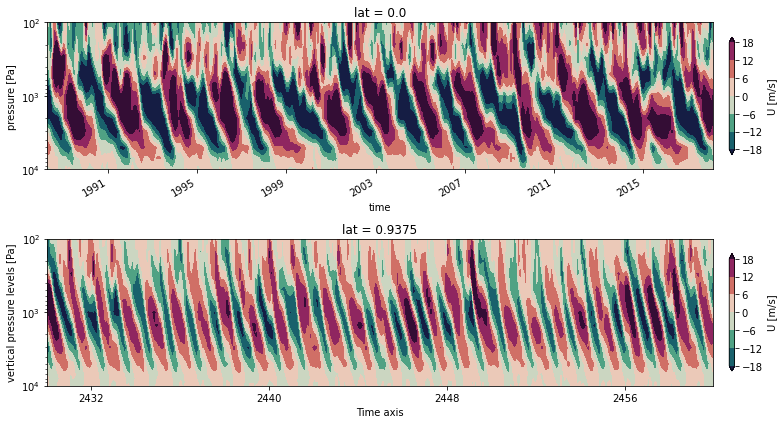

In [12]:
# Plot settings
umin1 = -18
umax1 = 18
ulevels1 = np.linspace(umin1,umax1,7)

cmap1 = cmocean.cm.curl

fig1,axs1 = plt.subplots(len(ds_pl_all)+1,1,figsize=(12,6))

# Zonal mean zonal equatorial wind
u_zt = u_pl_ei[-360:].sel(lat=0,method='nearest').mean('lon')
# Remove seasonal cycle
u_zt_a = u_zt.groupby('time.month') - u_zt.groupby('time.month').mean('time')
ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'U [m/s]', 'orientation':'vertical'}
u_zt_a.plot.contourf(x='time',y='lev',ax=axs1[0],levels=ulevels1,cmap=cmap1,cbar_kwargs=ckw)
    
for j in range(0,len(ds_pl_all)):
    i = j+1
    exp = exp_list[j]
    ds_pl = ds_pl_all[j]
    
    # Zonal mean zonal equatorial wind
    u_zt = ds_pl['u'][-360:].sel(lat=0,method='nearest').mean('lon')
    
    # Remove seasonal cycle
    u_zt_a = u_zt.groupby('time.month') - u_zt.groupby('time.month').mean('time')
    
    ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both', 'label':'U [m/s]', 'orientation':'vertical'}
    u_zt_a.plot.contourf(x='time',y='pressure_levels',ax=axs1[i],levels=ulevels1,cmap=cmap1,cbar_kwargs=ckw)

for ax in axs1:
    ax.set_yscale('log')
    ax.set_ylim([100,10000])
    ax.invert_yaxis()

fig1.tight_layout()
fig1.savefig('qbo_%s_erai.png' % (exp,),format='png')

In [29]:
def psd(ut):
    u = ut.values
    freq = np.fft.rfftfreq(u.shape[0])
    df = 1. / u.shape[0]
    uhat = np.fft.rfft(u)
    uabs = np.abs(uhat) / u.shape[0]
    u_psd = uabs**2 / df 
    return freq,u_psd

def ucomp(ut,up):
    u = ut.values
    
    # Identify wind flips from negative to positive 
    us = np.sign(u)
    uf = np.where( (us[0:-1]==-1) & (us[1:]==1) )[0]
    
    # Make composites of 5 step before and 45 steps after event
    uc = np.zeros((50))
    xc = np.arange(-5,45)
    n = 0
    for f in uf:
        if (f > 5) and (f < u.shape[0]-45):
            uc = uc + u[f-5:f+45]
            n = n + 1
    uc = uc / n

<xarray.DataArray 'u' (time: 360)>
dask.array<mean_agg-aggregate, shape=(360,), dtype=float32, chunksize=(120,), chunktype=numpy.ndarray>
Coordinates:
    lat              float32 0.9375
    pressure_levels  float32 2e+03
    time_centered    (time) object dask.array<chunksize=(120,), meta=np.ndarray>
  * time             (time) object 2430-01-16 12:00:00 ... 2459-12-16 12:00:00
<xarray.DataArray 'u' (time: 360)>
dask.array<getitem, shape=(360,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    lat              float32 0.9375
    pressure_levels  float32 2e+03
    time_centered    (time) object dask.array<chunksize=(1,), meta=np.ndarray>
  * time             (time) object 2430-01-16 12:00:00 ... 2459-12-16 12:00:00
    month            (time) int64 1 2 3 4 5 6 7 8 9 10 ... 4 5 6 7 8 9 10 11 12


/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


[  0  15  29  42  55  68  81  94 109 123 137 150 164 178 193 207 219 232
 246 260 273 285 298 311 326 339 354]
0
15
29
42
55
68
81
94
109
123
137
150
164
178
193
207
219
232
246
260
273
285
298
311
326
339
354


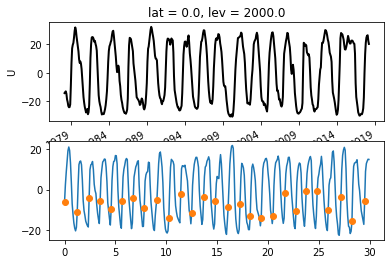

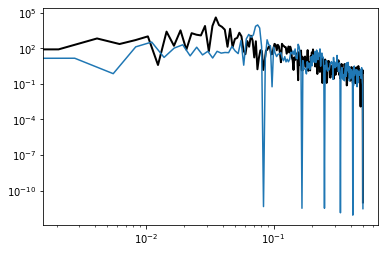

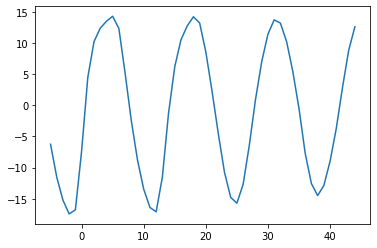

In [42]:
# Select 20 hPa for time series analysis
fig1, ax1 = plt.subplots(2,1)
fig2, ax2 = plt.subplots(1,1)
fig3, ax3 = plt.subplots(1,1)

# Zonal mean zonal equatorial wind
u_zt = u_pl_ei.sel(lat=0,method='nearest').sel(lev=2000).mean('lon')
# Remove seasonal cycle
u_zt_a = u_zt.groupby('time.month') - u_zt.groupby('time.month').mean('time')

u_zt_a.plot(ax=ax1[0],label='ERA-I',color='k',linewidth=2)

# Spectral analysis
freq, u_psd = psd(u_zt_a)
ax2.loglog(freq,u_psd,label='ERA-I',color='k',linewidth=2)

for j in range(0,len(ds_pl_all)):
    exp = exp_list[j]
    ds_pl = ds_pl_all[j]
    
    # Zonal mean zonal equatorial wind
    u_zt = ds_pl['u'][-360:].sel(lat=0,method='nearest').sel(pressure_levels=2000).mean('lon')
    print(u_zt)
    
    # Remove seasonal cycle
    u_zt_a = u_zt.groupby('time.month') - u_zt.groupby('time.month').mean('time')
    print(u_zt_a)
    
    #u_zt_a.plot(ax=ax1,label='%s' % (exp,))
    x = np.arange(0,u_zt_a.values.shape[0],1) / 12
    ax1[j+1].plot(x,u_zt_a.values)
    
    ax1[j+1].plot(x[uf],u[uf],'o')
    
    freq, u_psd = psd(u_zt_a)
    ax2.loglog(freq,u_psd,label='%s' % (exp,))
    
    ax3.plot(xc,uc)

#fig1.tight_layout()
#fig1.savefig('qbo_%s_erai.png' % (exp,),format='png')

<xarray.DataArray 'u' (time: 360)>
dask.array<mean_agg-aggregate, shape=(360,), dtype=float32, chunksize=(120,), chunktype=numpy.ndarray>
Coordinates:
    lat              float32 0.9375
    pressure_levels  float32 2e+03
    time_centered    (time) object dask.array<chunksize=(120,), meta=np.ndarray>
  * time             (time) object 2430-01-16 12:00:00 ... 2459-12-16 12:00:00

## Surface pressure and zonal wind

## Winds

## Temperature biases